<a href="https://colab.research.google.com/github/aderobaki/Data-Science-Projs/blob/workflows/Sales_Data_prediction_using_Time_series_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets first discuss what we are given and what we have to predict.
About our dataset :

We have in our training data :- 
1. date - every date of items sold
2. date_block_num - this number given to every month
3. shop_id - unique number of every shop
4. item_id - unique number of every item
5. item_price - price of every item
6. item_cnt_day - number of items sold on a particular day 

We have in our testing data :- 
1. ID - unique for every (shop_id,item_id) pair.
2. shop_id - unique number of every shop
3. item_id - unique number of every item

Now what we have to predict ?
we have to predict how many items of a type from each shop  will be sold in a whole month.
Our submission should have ID and item_cnt_month columns.

What is our approach?
our approach will be simple.
Our features will be number of items sold in month from a shop excluding last month data because that will our labels, that we help our model learn to predict next sequence. And for testing will use number of items sold in month from a shop excluding first month like this dimension of our data remains same. Our model will predict the next sequence and that we will be our results. This is pretty simple approach but its good for start. Please try some different approaches also. 
And please let me know if I did something wrong. If you like it please vote it up.


### **File descriptions**
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

# To tune model, get different metric scores, and split data
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from sklearn.model_selection import GridSearchCV
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df_train= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sales Data Prediction/sales_train.csv")
df_test= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sales Data Prediction/test.csv")

In [4]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
df_train.sample(10, random_state=42)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2472142,06.02.2015,25,31,11208,699.0,1.0
1044690,21.11.2013,10,31,19525,149.0,1.0
2367559,03.01.2015,24,42,16169,299.0,1.0
1793501,18.07.2014,18,42,2737,199.0,1.0
1585639,13.04.2014,15,2,15229,1199.0,1.0
1229976,27.12.2013,11,57,2269,799.0,1.0
183439,08.02.2013,1,31,18151,149.0,1.0
2343443,08.01.2015,24,27,6184,699.0,1.0
485890,09.05.2013,4,54,4908,899.0,1.0
431646,27.04.2013,3,42,2447,1999.0,1.0


In [8]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [9]:
df_train.shape

(2935849, 6)

### Data Preprocessing

In [10]:
#convert negative values in item_price
df_train['item_price'] = abs(df_train['item_price'])
df_train['item_cnt_day'] = abs(df_train['item_cnt_day'])

In [11]:
#change date from obj to datetime

df_train['date'] = df_train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [12]:
df_train['month'] = df_train['date'].dt.to_period('M').astype(str)


In [13]:
df_train['month'] = pd.to_datetime(df_train['month'])
df_train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month             datetime64[ns]
dtype: object

In [14]:
df_train["sale_revenue"]=df_train["item_cnt_day"] * df_train["item_price"] 

In [15]:
df_train.sample(10, random_state=42)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,sale_revenue
2472142,2015-02-06,25,31,11208,699.0,1.0,2015-02-01,699.0
1044690,2013-11-21,10,31,19525,149.0,1.0,2013-11-01,149.0
2367559,2015-01-03,24,42,16169,299.0,1.0,2015-01-01,299.0
1793501,2014-07-18,18,42,2737,199.0,1.0,2014-07-01,199.0
1585639,2014-04-13,15,2,15229,1199.0,1.0,2014-04-01,1199.0
1229976,2013-12-27,11,57,2269,799.0,1.0,2013-12-01,799.0
183439,2013-02-08,1,31,18151,149.0,1.0,2013-02-01,149.0
2343443,2015-01-08,24,27,6184,699.0,1.0,2015-01-01,699.0
485890,2013-05-09,4,54,4908,899.0,1.0,2013-05-01,899.0
431646,2013-04-27,3,42,2447,1999.0,1.0,2013-04-01,1999.0


In [16]:
df_train.shape

(2935849, 8)

### **Exploratory Data Analsyis**

In [17]:
# General statistics
def stats(df,x):
    print(f"Variable: {x}")
    print(f"Type of variable: {df[x].dtype}")
    print(f"Total observations: {df[x].shape[0]}")
    detect_null_val = df[x].isnull().values.any()
    if detect_null_val:
        print(f"Missing values: {df[x].isnull().sum()} ({(df[x].isnull().sum() / df[x].isnull().shape[0] *100).round(2)}%)")
    else:
        print(f"Missing values? {df[x].isnull().values.any()}")
    print(f"Unique values: {df[x].nunique()}")
    if df[x].dtype != "O":
        print(f"Min: {int(df[x].min())}")
        print(f"25%: {int(df[x].quantile(q=[.25]).iloc[-1])}")
        print(f"Median: {int(df[x].median())}")
        print(f"75%: {int(df[x].quantile(q=[.75]).iloc[-1])}")
        print(f"Max: {int(df[x].max())}")
        print(f"Mean: {df[x].mean()}")
        print(f"Std dev: {df[x].std()}")
        print(f"Variance: {df[x].var()}")
        print(f"Skewness: {scipy.stats.skew(df[x])}")
        print(f"Kurtosis: {scipy.stats.kurtosis(df[x])}")
        print("")
        
        # Percentiles 1%, 5%, 95% and 99%
        print("Percentiles 1%, 5%, 95%, 99%")
        display(df[x].quantile(q=[.01, .05, .95, .99]))
        print("")
    else:
        print(f"List of unique values: {df[x].unique()}")

# Histogram
def hist(x):
    plt.hist(df[x], bins=25)
    plt.title(x, fontsize=10, loc="right")
    plt.xlabel('Relative frequency')
    plt.ylabel('Absolute frequency')
    plt.show()


In [18]:
stats(df_train,"item_cnt_day")

Variable: item_cnt_day
Type of variable: float64
Total observations: 2935849
Missing values? False
Unique values: 189
Min: 1
25%: 1
Median: 1
75%: 1
Max: 2169
Mean: 1.2477780703299113
Std dev: 2.6163906491029
Variance: 6.8455000287130945
Skewness: 273.59462104983817
Kurtosis: 178139.66271572706

Percentiles 1%, 5%, 95%, 99%


0.01    1.0
0.05    1.0
0.95    2.0
0.99    5.0
Name: item_cnt_day, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


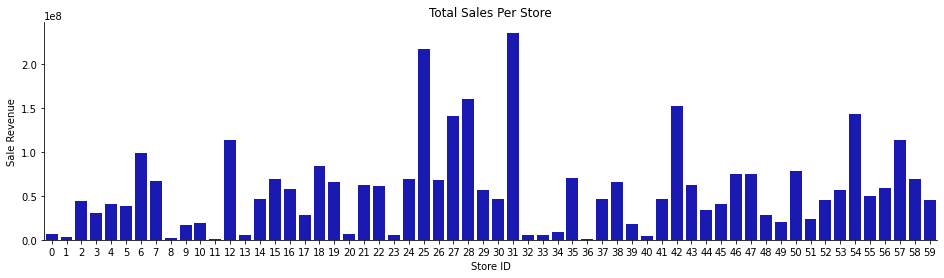

In [19]:
 #lets see the revenue per shop
 store = df_train.groupby('shop_id')['sale_revenue'].sum().reset_index()
  
fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(store.shop_id, store.sale_revenue, color='mediumblue')
ax.set(xlabel = "Store ID",ylabel = "Sale Revenue", title = "Total Sales Per Store")
    
sns.despine()

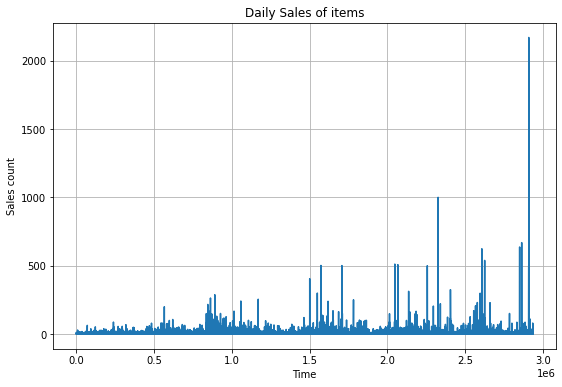

In [20]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(df_train['item_cnt_day'])
plt.title('Daily Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
plt.show()

In [21]:
df_train[['shop_id','item_id','item_price','item_cnt_day']].corr()

,shop_id,item_id,item_price,item_cnt_day
shop_id,1.000000,0.029396,-0.024034,-0.005329
item_id,0.029396,1.000000,-0.134104,0.016290
item_price,-0.024034,-0.134104,1.000000,0.011841
item_cnt_day,-0.005329,0.016290,0.011841,1.000000


### **Time Series Analysis**

In [22]:
train_dataset = df_train.pivot_table(index=['shop_id', 'item_id'], values=['item_cnt_day'], columns=['date_block_num'], fill_value=0, aggfunc='sum')

In [23]:
train_dataset.head(3)

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  

[3 rows x 34 columns]

In [24]:
# Now we will merge our pivot table with the test_data because we want to keep the data of items we have
# predict
data_lstm = pd.merge(df_test,train_dataset,on = ['item_id','shop_id'],how = 'left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
data_lstm.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# lets fill all NaN values with 0 and drop shop_id and item_id columns 
data_lstm.fillna(0,inplace = True)
data_lstm.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
data_lstm.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
data_lstm.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
data_lstm.shape

(214200, 34)

In [29]:
# the last column is our label
#y_train = df_test.iloc[:,[33]]
# X we will keep all columns execpt the last one 
#X_train = df_test.iloc[:,0:34]
# for test we keep all the columns execpt the first one
#X_test = df_test.iloc[:,1:34]
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(data_lstm.values[:,:-1],axis = 2)
# the last column is our label
y_train = data_lstm.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(data_lstm.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [30]:
# importing libraries required for our model
import keras
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [31]:
# our defining our model 
model_lstm = Sequential()
model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [32]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 5000,epochs = 10)

Epoch 1/10
43/43 [==============================] - 31s 615ms/step - loss: 30.6316 - mean_squared_error: 30.6316
Epoch 2/10
43/43 [==============================] - 23s 538ms/step - loss: 30.2956 - mean_squared_error: 30.2956
Epoch 3/10
43/43 [==============================] - 24s 570ms/step - loss: 30.0754 - mean_squared_error: 30.0754
Epoch 4/10
43/43 [==============================] - 24s 545ms/step - loss: 29.9337 - mean_squared_error: 29.9337
Epoch 5/10
43/43 [==============================] - 23s 524ms/step - loss: 29.8523 - mean_squared_error: 29.8523
Epoch 6/10
43/43 [==============================] - 23s 526ms/step - loss: 29.7679 - mean_squared_error: 29.7679
Epoch 7/10
43/43 [==============================] - 22s 514ms/step - loss: 29.7886 - mean_squared_error: 29.7886
Epoch 8/10
43/43 [==============================] - 24s 557ms/step - loss: 29.6467 - mean_squared_error: 29.6467
Epoch 9/10
43/43 [==============================] - 24s 554ms/step - loss: 29.6614 - mean_square

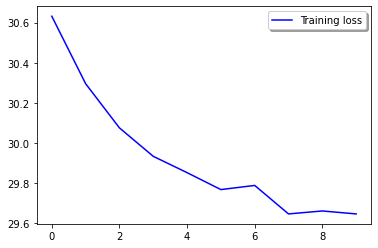

In [33]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [34]:
# creating submission file 
submission_pfs = model_lstm.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':df_test['ID'],'item_cnt_month':submission_pfs.ravel()})


In [35]:
submission.head(3)

,ID,item_cnt_month
0,0,0.455931
1,1,0.140330
2,2,0.809457
